# Customer Lifetime Value or CLV (Total profit derived from customer)
> CLV = PurchaseCount for a customer * Transaction value for each customer

## Setting (Online Retail)- 
- Non-Contractual ("death" of customer unobserved) 
- Continuous Purchases ("non-periodicity" of purchases - can happen anytime)

### Importing libraries (and modules)

**Required lib(s)**

In [111]:
#Data manipulations
import pandas as pd  
import datetime as dt  

#Vizualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

#CLV library and modules
!pip install lifetimes
from lifetimes.plotting import *  #plotting functions (especific plots CLV related)
from lifetimes.utils import *   #utility functions (convert trans data to RFM matrix)
from lifetimes.estimation import *
from lifetimes import BetaGeoFitter  #PurchaseCount Model
from lifetimes import GammaGammaFitter  #Value Model

**Good-to-have**

In [68]:
import warnings
warnings.filterwarnings('ignore')

### Importing data and high-level inspection

**Imports**

In [43]:
#Importing file from the web into a Pandas DF
df=pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")

**High-level Inspection**

In [94]:
#Checking a few rows from the top
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [98]:
#Getting info (rows, cols, datatypes)
print(df.info(),'\n')

#Getting some Summary Stats (including all cols types)
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None 



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


### Data Cleaning and Manipulations

**Cleaning - Character columns**

In [104]:
#Filtering - Removing rows where customer ID is NULL
df1=df[df['CustomerID'].notnull()]

**Cleaning - Numeric columns**

In [123]:
#Filtering - Removing rows where quantity and unit-price -ve => "returns"
##Note: Rows where unit price <=0 is (40); but for unit price <0 it's (zero)
##Note: Rows where quantity <=0 is (8905); and it's for quantity <0 
df2=df1[(df1['Quantity']>0)] 

**Cleaning - Datetime columns**

In [124]:
#Extracting dates out of datetime column
df2['InvoiceDate']=df2['InvoiceDate'].dt.date

**Manipulations - 1**

In [125]:
#Adding a required column for our model (i.e. Revenue)
df2['Revenue']=df2['UnitPrice']*df2['Quantity']

#Keeping only those columns that we need for analysis
df3=df2[['CustomerID','InvoiceDate','Revenue']]

#High-level inspection of our analytical data
print(df3.head(),'\n')
print(df3.info(), '\n')
print(df3.describe(include="all"))

   CustomerID InvoiceDate  Revenue
0     17850.0  2010-12-01    15.30
1     17850.0  2010-12-01    20.34
2     17850.0  2010-12-01    22.00
3     17850.0  2010-12-01    20.34
4     17850.0  2010-12-01    20.34 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 3 columns):
CustomerID     397924 non-null float64
InvoiceDate    397924 non-null object
Revenue        397924 non-null float64
dtypes: float64(2), object(1)
memory usage: 12.1+ MB
None 

           CustomerID InvoiceDate        Revenue
count   397924.000000      397924  397924.000000
unique            NaN         305            NaN
top               NaN  2011-11-06            NaN
freq              NaN        3423            NaN
mean     15294.315171         NaN      22.394749
std       1713.169877         NaN     309.055588
min      12346.000000         NaN       0.000000
25%      13969.000000         NaN       4.680000
50%      15159.000000         NaN      11.800000
75%      167

**Manipulations - 2**

In [120]:
#Creating the "lifetimes object" - freq, recency, T, monetary_value
##Note: freq - no. of repeated trans in obs period
##Note: recency - duration btwn first trans to recent trans
##Note: T - duration btwn first trans to end of obs period
##Note: monetary_value - avg value (profit, revenue, etc.) per repeat transaction
df4=summary_data_from_transaction_data(transactions=df3,
                                       customer_id_col='CustomerID',
                                       datetime_col='InvoiceDate',
                                       monetary_value_col='Revenue',
                                       observation_period_end='2011-12-9')

#High-level inspection of our final analytical data
print(df4.head(),'\n')
print(df4.info(), '\n')
print(df4.describe(include="all"))

            frequency  recency      T  monetary_value
CustomerID                                           
12346.0           0.0      0.0  325.0        0.000000
12347.0           6.0    365.0  367.0      599.701667
12348.0           3.0    283.0  358.0      301.480000
12349.0           0.0      0.0   18.0        0.000000
12350.0           0.0      0.0  310.0        0.000000 

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4339 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
frequency         4339 non-null float64
recency           4339 non-null float64
T                 4339 non-null float64
monetary_value    4339 non-null float64
dtypes: float64(4)
memory usage: 169.5 KB
None 

         frequency      recency            T  monetary_value
count  4339.000000  4339.000000  4339.000000     4339.000000
mean      2.864024   130.741415   222.782899      306.944168
std       5.952745   132.210176   117.883623     2612.453380
min       0.000000     0.000000     0.000000      

### EDA of analytical dataset

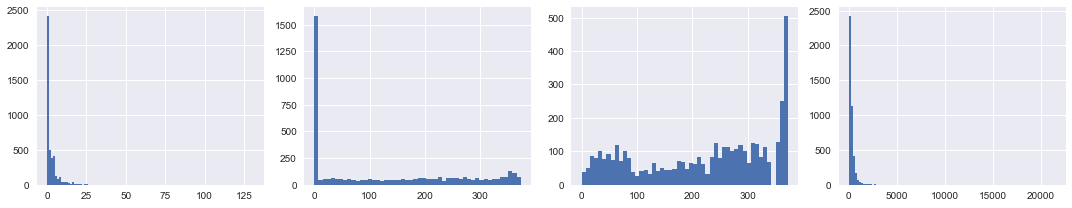

In [261]:
#Frequency distribution of variables (RFM)
fig,axes=plt.subplots(1,4, figsize=(15,3))
axes[0].hist(df4['frequency'],bins=100)
axes[1].hist(df4['recency'],bins=50)
axes[2].hist(df4['T'],bins=50)
axes[3].hist(df4[df4['monetary_value']<=50000]['monetary_value'],bins=100)
plt.tight_layout()

In [251]:
#Checking values with 0 value in ADS (These are one time buyers or non-repeat buyers)
print('% of customers with zero frequen', sum(df4['frequency']==0)/len(df4))
print('% of customers with zero recency', sum(df4['recency']==0)/len(df4))
print('% of customers with zero mon_val', sum(df4['monetary_value']==0)/len(df4))

% of customers with zero frequen 0.356994699239
% of customers with zero recency 0.356994699239
% of customers with zero mon_val 0.356994699239


### CLV Models (Probablistic approach) 

**Probabilistic approach brief:** Characterising customer behaviour by constraining below listed 3 latent (unobserved) params at customer level w.r.t. relevant distributions and make inferences about future purchases and value:

- Quantity or PurchaseCount 
- Value or Spend/Profit
- Lifetime (Common for most models)

![title](https://i.pinimg.com/originals/de/da/e0/dedae0e5f9d6f98e434f6db3bc0599ee.png)


### CLV Model Variations or Types

**1) Quantity or PurchaseCount (e.g. Pareto/NBD, BG/NBD)** -> Imagine each customer has two separate coins that they flip to:
    
- See if they want to be "alive" or "dead" with some prob. - indep. binary outcome (e.g. Expo., Constant)
- Decide how many purchases they gonna make with some prob. - indep. discrete count (e.g. Poisson: mu=sigma)
    
_Note_: No mechanism for the interplay between purchases and whether client is alive, thus use Bayesian Hierarchical models to answer this issue. 
    
_How_: Hierarchical Bayesian Model - Each latent params (PurchaseCount prob and DeathRate prob) is constrained by a prior distributions (**each distribution has params and the goal is to find these params that will help us to infer latent params**) respectively representing our belief of how these params are distributed in our customer cohort; in layman terms using knowledge of customer population to infer or generalise values of latent params more accurately 

_Model Usage (when to use):_ 
These models have a higher predictive accuracy when the proportion of historically active customers (known as the ‘penetration’) is smaller, the average historical frequency (called the ‘frequency’) is higher, the variance of such a frequency (called the ‘variance’) is lower, and the degree of concentration of such a frequency among historically active customers (called the ‘concentration’) is higher
    
**2) Value or Spend/Profit (Gamma-Gamma Model)** -> Imagine each customer has a coin that they flip to :

- Decide how much they gonna spend with some prob. - indep. contin. outcome, right skew (e.g. Gamma)
    

### 1.1) Pareto/NBD Model
**Model Assumptions:**
    
    1) Each cust's #transactions follows a Poisson Process with rate λ - random purchases at constant rate
       >> λ follows a Gamma dist with shape r and rate α - each customer has his own purchase rate λ
    2) Each cust's Lifespan expo. dist. with death rate μ (slope) - cust. could die with prob. in expo. dec.  
       >> μ follows a Gamma dist with params a and b - each customer his own μ
    3) Purchasing rate and death rate are independently distributed
    
**Why use BG/NBD instead?**
    
- Easy to model and implement
- Fair assumption that death rate may stay constant

### 1.2) BG/NBD Model (A practical alternative to Pareto/NBD)

**BG/NBD Model Assumptions:**

    1) Each cust's #transactions follows a Poisson Process with rate λ - random purchases at constant rate
       >> λ follows a Gamma dist with shape r and rate α - each customer has his own purchase rate λ
    2) After each purchase probability of death remains constant p - customer could die with constant prob p
       >> p follows a Beta distribution with parameters a and b - each customer his own constant p
    3) Purchase rate and death rate are independently distributed - purchase rate is indep of death rate

**Fitting BG/NBD Model to ADS**

In [290]:
#BG/NBD Model
BG_NBD=BetaGeoFitter(penalizer_coef=0.0)
BG_NBD.fit(frequency=df4['frequency'], 
           recency=df4['recency'], 
           T=df4['T'])
print(BG_NBD)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.93, b: 2.07, r: 0.83>


**Visualising BG/NBD Model Outputs**
    1. PurchaseCount - Expected purchases next peirod
    2. Lifetime - Prob of survival nxt period

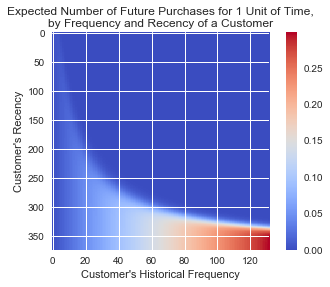

In [281]:
#Plot1: Expected No. of purchases per unit time w.r.t Freq, Rece
#Note: Customers who have purchased a lot and purchased recently will likely be the best customers in the future
plot_frequency_recency_matrix(BG_NBD)

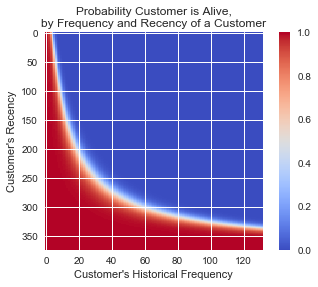

In [280]:
#Plot2: Prob of customer being alive w.r.t Freq, Rece
#Note: Customers who have purchased recently are almost surely “alive”. Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out
plot_probability_alive_matrix(BG_NBD)

** BG/NBD Model Predictions**

In [287]:
#Predicting expected PurchaseCount till time t (starting from end of calibration period till period we are interested)
#Getting our Top 5 customers (in terms of exp no. of purchases till time t)
##Note: 't' depends on case to case (some busines interested in a month or half-year or year params for customer)
t=90
df4['PredPurc_till_t']=BG_NBD.conditional_expected_number_of_purchases_up_to_time(t=t,frequency=df4['frequency'],recency=df4['recency'],T=df4['T'])
df4.sort_values(by='PredPurc_till_t').tail(5)

,frequency,recency,T,monetary_value,PredPurc_till_t
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,18.086994
15311.0,89.0,373.0,373.0,677.729438,18.290673
17841.0,111.0,372.0,373.0,364.452162,22.770336
12748.0,113.0,373.0,373.0,298.360885,23.177656
14911.0,131.0,372.0,373.0,1093.661679,26.842807


**Assessing BG/NBD Model Fit**

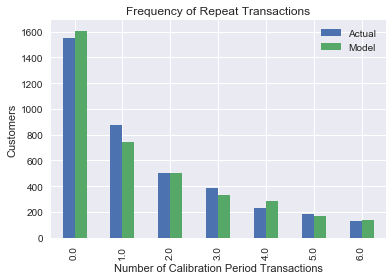

In [288]:
#Actual Vs. Pred repeat purch in calibration period
plot_period_transactions(BG_NBD)

**CrossValidation**

In [305]:
#Using in-built utility functions to get df5 from trans data
##Note: Using about 75% for calibration or training (25% holdout = obs-calib). 
##Note: Better performance when both period almost equal
df5=calibration_and_holdout_data(df3,
                                 customer_id_col='CustomerID',
                                 datetime_col='InvoiceDate',
                                 monetary_value_col='Revenue',
                                 calibration_period_end='2011-06-08',
                                 observation_period_end='2011-12-9')

#High-level inspection of our final analytical data
print(df5.head(),'\n')
print(df5.info(), '\n')
print(df5.describe(include="all"))

            frequency_cal  recency_cal  T_cal  monetary_value_cal  \
CustomerID                                                          
12346.0               0.0          0.0  141.0                0.00   
12347.0               2.0        121.0  183.0              555.82   
12348.0               2.0        110.0  174.0              297.22   
12350.0               0.0          0.0  126.0                0.00   
12352.0               3.0         34.0  112.0              421.77   

            frequency_holdout  monetary_value_holdout  duration_holdout  
CustomerID                                                               
12346.0                   0.0                0.000000               184  
12347.0                   4.0               25.373163               184  
12348.0                   1.0              103.333333               184  
12350.0                   0.0                0.000000               184  
12352.0                   3.0               20.090000               184 

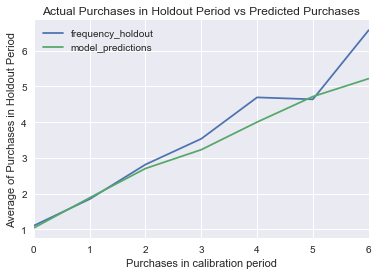

In [308]:
#Fitting BG/NBD Model
BG_NBD.fit(df5['frequency_cal'],df5['recency_cal'],df5['T_cal'])

#Assessing model-data fit ('PurchaseCount' in holdout for given calib 'PurchaseCount' - Act. holdout period vs. Pred)
plot_calibration_purchases_vs_holdout_purchases(BG_NBD,df5)

In [375]:
#Bottom 5 customers having at least one repeat trans (in terms of exp no. of purchases till time t)
t=90
df5['PredPurc_till_t']=BG_NBD.conditional_expected_number_of_purchases_up_to_time(t=t,frequency=df5['frequency_cal'],recency=df5['recency_cal'],T=df5['T_cal'])
df5[df5['frequency_cal']>0].sort_values(by='PredPurc_till_t').head(5)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,PredPurc_till_t
CustomerID,,,,,,,,
17850.0,1.0,1.0,189.0,3891.87,0.0,0.000000,184,0.625784
17897.0,1.0,6.0,189.0,268.73,1.0,3.142381,184,0.625784
12433.0,1.0,7.0,189.0,1867.98,4.0,35.123626,184,0.625784
17951.0,1.0,15.0,189.0,114.00,1.0,54.458182,184,0.625784
17905.0,1.0,21.0,189.0,192.40,2.0,67.681667,184,0.625784


**Entire History of You (Customer)**

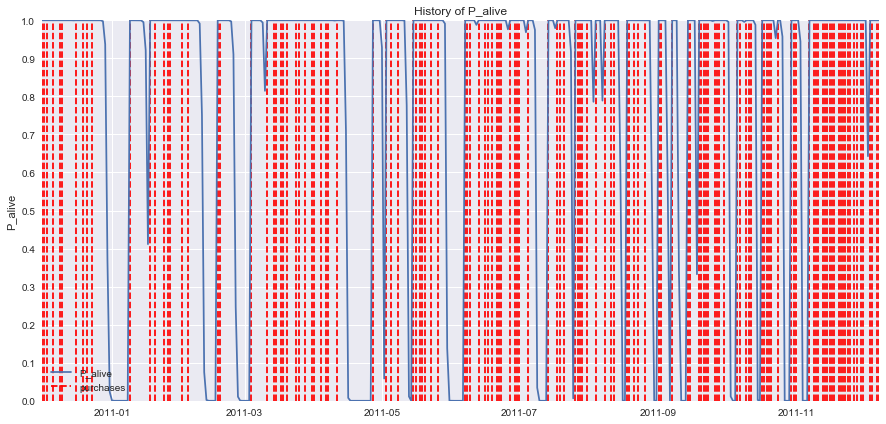

In [354]:
#Plotting history of a customer being alive
#Best Customer
BestCustID=14911
plt.figure(figsize=(15,7))
plot_history_alive(model=BG_NBD, t=365, 
                   transactions=df3[df3['CustomerID']==BestCustID], 
                   datetime_col='InvoiceDate')

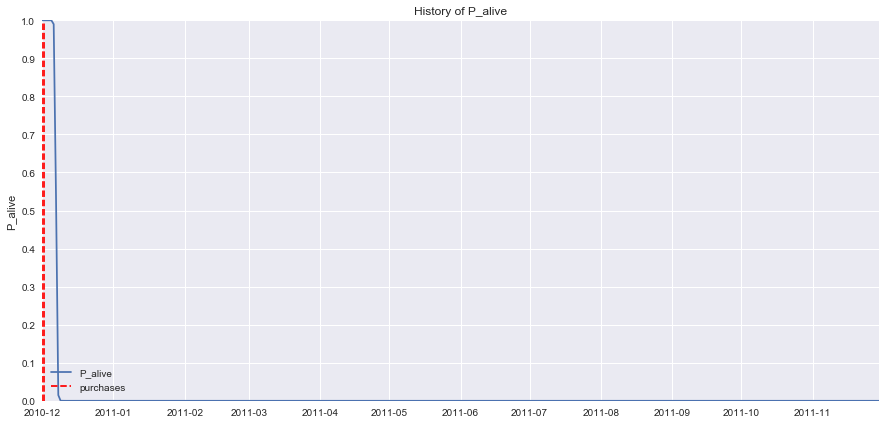

In [355]:
#Worst Customer(s)
WorstCustID=17850
plt.figure(figsize=(15,7))
plot_history_alive(model=BG_NBD, t=365, 
                   transactions=df3[df3['CustomerID']==WorstCustID], 
                   datetime_col='InvoiceDate')

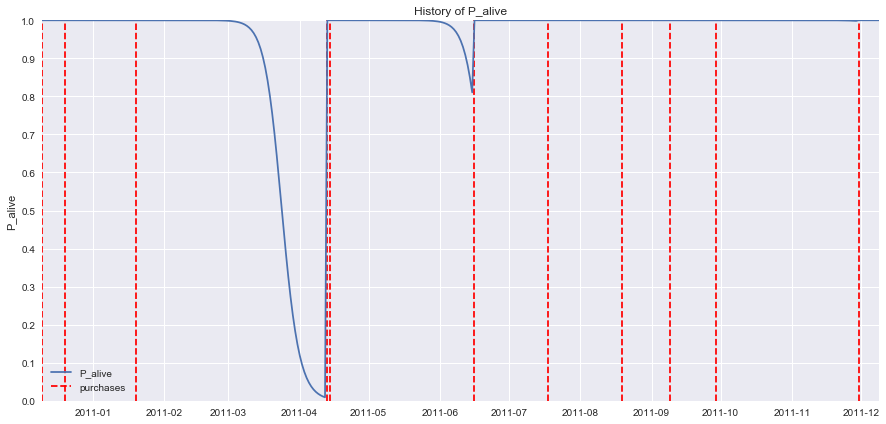

In [372]:
#Random Customer
RandCustID=14062
plt.figure(figsize=(15,7))
plot_history_alive(model=BG_NBD, t=365, 
                   transactions=df3[df3['CustomerID']==RandCustID], 
                   datetime_col='InvoiceDate')

### 2.1) Gamma-Gamma Model

**Gamma-Gamma Model Assumptions:**

    1) Trans value of a customer varies randomly around his/her avg. trans value
       >> Customers' trans value follow a Gamma distribution - a customer makes more low value purchases than high
    2) Avg. trans value varies across cust, but doesnt vary w.r.t. time for any individual
       >> Avg. trans value follows a Gamma distribution too - many customers with low value than high value 
    3) Avg. value across cust is indep of trans process (Value can be modeled sep from purchase count & lifetime)

**Gamma-Gamma Model specific data manipulation**

In [382]:
#Filtering to keep repeat customers
##Note: Gamma-gamma model works for repeat customers only
df6=df4[df4['frequency']>0]

**Fitting Gamma-Gamma Model to ADS (modified)**

In [387]:
#Fitting Gamma-Gamma model
##Note: Model just takes frequency and monetary value as inputs from data
GGM=GammaGammaFitter(penalizer_coef=0.0)
GGM.fit(df6['frequency'],df6['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

**Gamma-gamma Model Predictions**

In [394]:
#Predicting expected average transaction value
#Getting our Top 5 customers with their expected avg trans value 
##Note: THIS IS NOT CLV YET!!!!
GGM.conditional_expected_average_profit(df6['frequency'],df6['monetary_value']).sort_values(ascending=False).head(5)

CustomerID
16446.0    78051.289664
15749.0    10173.137598
18102.0     8951.861956
12415.0     7323.918867
17450.0     7105.093906
dtype: float64

## The Big Question: What is the CLV?

> CLV (C,t) = Expected Total PurchaseCount (C,t) * Expected Avg Transaction Value (C)
    
where C is customer and t is time of interest (CLV for a day, month, year, etc.)

**BG/NBD Model for predicting Expected TotalPurchaseCount (per customer)**

In [395]:
#Fitting BG/NBD on our new ADS (repeat customers) first
BG_NBD.fit(df6['frequency'], 
           df6['recency'], 
           df6['T'])

<lifetimes.BetaGeoFitter: fitted with 2790 subjects, a: 0.01, alpha: 108.89, b: 0.16, r: 1.94>

**Gamma-Gamma Model for predicting Expected Avg Transaction Value AND CLV eventually (per customer)**

In [399]:
#Using Gamma-Gamma Model's 'CLV method' for CLV calculation
#Getting our Top 5 customers with their predicted CLV
GGM.customer_lifetime_value(BG_NBD,  #PurchaseCount Model
                            df6['frequency'],
                            df6['recency'],
                            df6['T'],
                            df6['monetary_value'],
                            time=3,  #months interested in
                            discount_rate=0.01  #monthly discount_rate
                           ).sort_values(ascending=False).head(5)

CustomerID
16446.0    60956.935539
14646.0    54349.266223
18102.0    44659.654281
17450.0    36754.651345
14096.0    28757.456401
Name: clv, dtype: float64

# References

    1) CLV Models - http://srepho.github.io/CLV/CLV
    2) Lifetimes Ref - https://github.com/CamDavidsonPilon/lifetimes
    3) Approach - https://www.datascience.com/blog/intro-to-predictive-modeling-for-customer-lifetime-value
    4) Gamma-Gamma Model - http://www.brucehardie.com/notes/025/gamma_gamma.pdf